<center>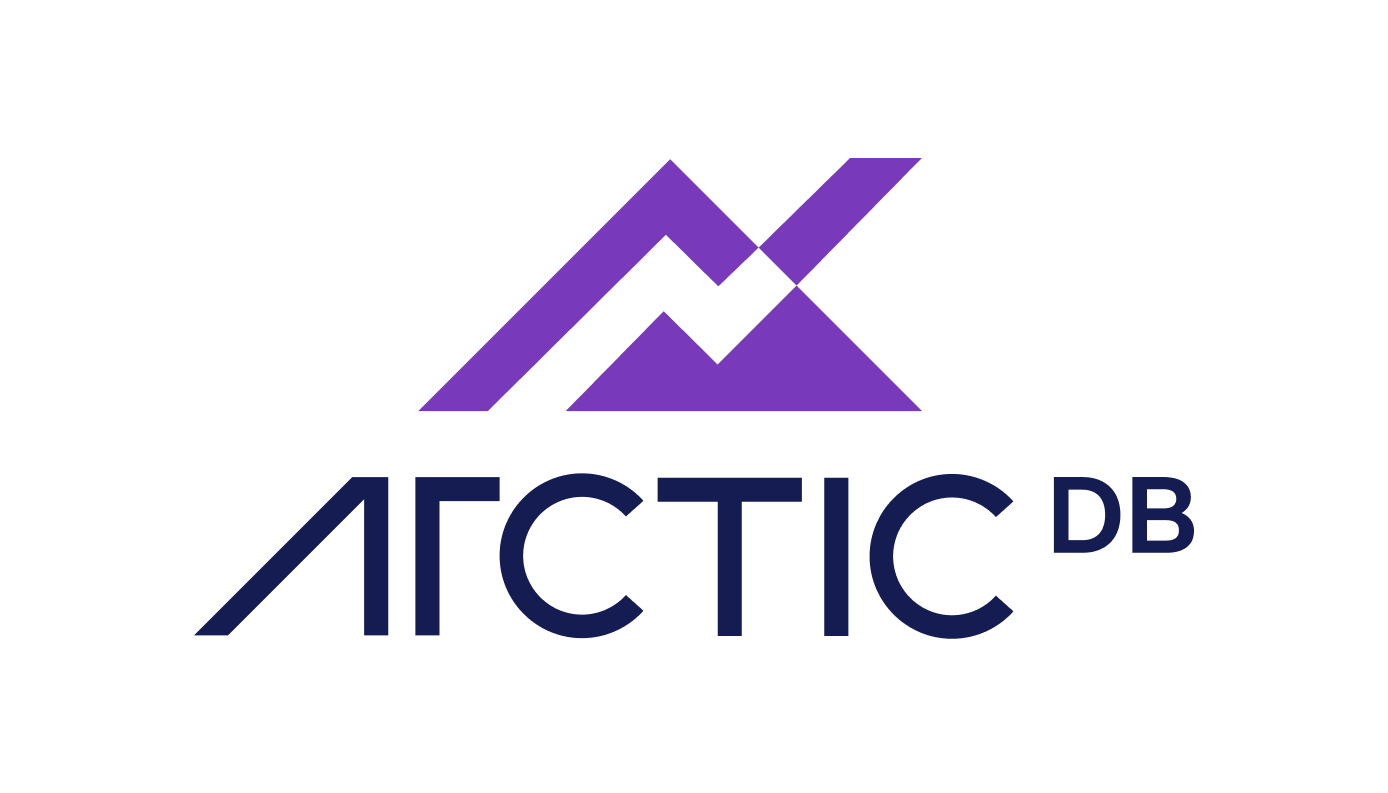
</center>

# ArcticDB Merge
<div role="alert" style="background-color:#FFF3CD;color:#856404;border:1px solid #FFEEBA;border-radius:10px;padding:12px 16px;font-size:14px;line-height:1.4;font-family:system-ui,-apple-system,Segoe UI,Roboto,'Helvetica Neue',Arial;display:flex;align-items:center;gap:8px;box-shadow:0 1px 0 rgba(0,0,0,0.04);">
  ⚠️ <span style="font-weight:600;margin-left:6px;">Warning:</span> The merge API is under development and subject to change. Additional features will be introduced in the future. The API is not subject to semver and can change in minor or patch releases. Stay tuned for updates! The API call at the moment is named merge_experimental but it will be changed to merge when the API becomes stable.
</div>

## Motivation
The merge API offers a straightforward way for users to modify or insert specific rows in their data. Data providers often issue corrections for particular entries, and the merge functionality can efficiently apply these updates.

### Example
Let's start with a quick example before exploring the details.

In this example, we have an ArcticDB library called `prices` that stores price data, and a symbol named `daily_prices` for daily prices. At some point, the data provider issued corrections for `2023-01-05`, `2023-01-07`, and `2023-01-19`. We want to apply these corrections, modifying only the affected rows.

Begin by importing the necessary modules.

In [1]:
import pandas as pd
import arcticdb
import numpy as np
from IPython.display import display
from arcticdb.version_store.library import MergeStrategy, MergeAction

Next, create an ArcticDB instance and a library.

In [2]:
ac = arcticdb.Arctic("lmdb://merge_example")
lib = ac.get_library("prices", create_if_missing=True)

Create an example prices DataFrame and store it in ArcticDB.

In [3]:
# Create example data
daily_prices = pd.DataFrame(
    data={
        "High": [102.5, 103.6, 101.7, 103.2, 104.8, 106.0, 108.9, 107.6, 109.3, 108.7, 
                 111.1, 113.5, 113.2, 115.0, 112.3, 115.9, 117.3, 118.6, 119.8, 119.1],
        "Low": [100.5, 101.8, 99.7, 100.9, 101.7, 103.4, 106.2, 104.8, 107.5, 106.3, 
                109.1, 110.8, 110.2, 111.7, 109.6, 112.7, 114.0, 115.4, 116.5, 116.2],
        "Volume": [1200, 1500, 900, 1400, 1600, 1900, 2500, 2300, 1800, 2100, 
                   2000, 2700, 2600, 3000, 2200, 3100, 2800, 3200, 3500, 3400],
    },
    index=pd.date_range(start="2023-01-01", periods=20, freq="D")
)
daily_prices

,High,Low,Volume
2023-01-01,102.5,100.5,1200
2023-01-02,103.6,101.8,1500
2023-01-03,101.7,99.7,900
2023-01-04,103.2,100.9,1400
2023-01-05,104.8,101.7,1600
2023-01-06,106.0,103.4,1900
2023-01-07,108.9,106.2,2500
2023-01-08,107.6,104.8,2300
2023-01-09,109.3,107.5,1800
2023-01-10,108.7,106.3,2100


In [4]:
lib.write("daily_prices", daily_prices)

VersionedItem(symbol='daily_prices', library='prices', data=n/a, version=2, metadata=None, host='LMDB(path=/home/vasil/Documents/source/ArcticDB/docs/mkdocs/docs/notebooks/merge_example)', timestamp=1771501596070866899)

Create the correction DataFrame.

In [5]:
daily_prices_correction = pd.DataFrame(
    data={
        "High":  [3000.0, 4000.0, 5000.0],
        "Low":   [1000.0, 2000.0, 3000.0],
        "Volume":[10000, 20000, 30000]
    },
    index=pd.DatetimeIndex([pd.Timestamp("2023-01-05"), pd.Timestamp("2023-01-07"), pd.Timestamp("2023-01-19")])
)
daily_prices_correction

,High,Low,Volume
2023-01-05,3000.0,1000.0,10000
2023-01-07,4000.0,2000.0,20000
2023-01-19,5000.0,3000.0,30000


Perform the merge update using the correction data. Ensure that both daily_prices_correction and the stored data are sorted. By default, two rows in DataFrames with a datetime index are considered matching if their indexes are equal.

In [6]:
lib.merge_experimental("daily_prices", daily_prices_correction, strategy=MergeStrategy(matched="update", not_matched_by_target="do_nothing"))
print("Merged result")
display(lib.read("daily_prices").data)
print("Diff between merged and original data")
daily_prices.compare(lib.read("daily_prices").data, keep_equal=True)

Merged result


,High,Low,Volume
2023-01-01,102.5,100.5,1200
2023-01-02,103.6,101.8,1500
2023-01-03,101.7,99.7,900
2023-01-04,103.2,100.9,1400
2023-01-05,3000.0,1000.0,10000
2023-01-06,106.0,103.4,1900
2023-01-07,4000.0,2000.0,20000
2023-01-08,107.6,104.8,2300
2023-01-09,109.3,107.5,1800
2023-01-10,108.7,106.3,2100


Diff between merged and original data


High            Low         Volume       
             self   other   self   other   self  other
2023-01-05  104.8  3000.0  101.7  1000.0   1600  10000
2023-01-07  108.9  4000.0  106.2  2000.0   2500  20000
2023-01-19  119.8  5000.0  116.5  3000.0   3500  30000

### Merge vs. Update

ArcticDB also provides an `update` method, which requires sorted input. The key difference is that `update` overwrites all data between the start and end of the input, potentially removing any rows that fall within those bounds and are not in the input.

In [7]:
lib.write("prices_update_example", daily_prices)
lib.update("prices_update_example", daily_prices_correction)
lib.read("prices_update_example").data

,High,Low,Volume
2023-01-01,102.5,100.5,1200
2023-01-02,103.6,101.8,1500
2023-01-03,101.7,99.7,900
2023-01-04,103.2,100.9,1400
2023-01-05,3000.0,1000.0,10000
2023-01-07,4000.0,2000.0,20000
2023-01-19,5000.0,3000.0,30000
2023-01-20,119.1,116.2,3400


In the example above, the input to `update` included only rows for `2023-01-05`, `2023-01-07`, and `2023-01-19`. As a result, any data between `2023-01-05` and `2023-01-19` that was not present in the `update` input is omitted from the final result.

## Merge: Semantics and Behavior
In this context, the data stored in ArcticDB is referred to as the `target`, while the input to `merge` is called the `source`.

Merge works by performing a join between `target` and `source` on a subset of columns, and updating `target` based on the `strategy` parameter. If `target` is a time series, the index will **always** be included among the join columns. This is done to ensure that ordered date-time indexes stay ordered after performing a merge. Otherwise the following would be possible
```python
lib.write("sym", pd.DataFrame({"a": [1, 2, 3]}, index=pd.DatetimeIndex([pd.Timestamp(1), pd.Timestamp(2), pd.Timestamp(3)])))
lib.merge_experimental("sym", pd.DataFrame({"a": [2]}, index=pd.DatetimeIndex([pd.Timestamp(10)])), on=["a"])
print(lib.read("sym").data)
                               a
1970-01-01 00:00:00.000000001  1
1970-01-01 00:00:00.000000010  2
1970-01-01 00:00:00.000000003  3
```

### Strategies

The strategy is a named tuple that defines how `target` will be modified. Its members can be either case-insensitive strings (`update`, `insert`, or `do_nothing`) or members of the `MergeAction` enum.

* `matched` specifies what to do when a row in `source` matches a row in `target`. Acceptable values are `update` and `do_nothing`.
* `not_matched_by_target` specifies what to do when a row in `source` does not match any row in `target`. Acceptable values are `insert` and `do_nothing`.

#### Acceptable combinations

* `matched="update"`, `not_matched_by_target="do_nothing"`
* `matched="update"`, `not_matched_by_target="insert"`
* `matched="do_nothing"`, `not_matched_by_target="insert"`

#### Unacceptable combinations
* `matched="do_nothing"`, `not_matched_by_target="do_nothing"` - nothing is going to happen
* `matched="do_nothing"|"insert"|"update"`, `not_matched_by_target="update"` - cannot update a row that is not existing in the target
* `matched="insert"`, `not_matched_by_target="do_nothing"|"insert"|"update"` - while technically possible it doesn't make sense to insert duplicates

#### Examples
* `MergeStrategy(matched="update", not_matched_by_target="do_nothing")` updates only the rows in `target` that match the selected columns. Rows that do not match remain unchanged, and new rows are not inserted. If a row in `source` matches multiple rows in `target`, all matching rows in `target` will be updated.

In [8]:
data_with_duplicates = pd.DataFrame(
    {"Bid": [100, 101, 102], "Ask": [101.1, 101, 102.5]},
    index=pd.DatetimeIndex([pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-01-01 09:00:00")])
)
lib.write("merge_update_with_duplicates", data_with_duplicates)
print("Original data")
display(lib.read("merge_update_with_duplicates").data)
lib.merge_experimental(
    "merge_update_with_duplicates",
    pd.DataFrame(
        {"Bid": [105, 102], "Ask": [105.3, 102]},
        index=pd.DatetimeIndex([pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-02-01 08:00:00")])
    ),
    MergeStrategy(matched="update", not_matched_by_target="do_nothing")
)
print("Data after merge")
display(lib.read("merge_update_with_duplicates").data)

Original data


,Bid,Ask
2025-01-01 08:00:00,100,101.1
2025-01-01 08:00:00,101,101.0
2025-01-01 09:00:00,102,102.5


Data after merge


,Bid,Ask
2025-01-01 08:00:00,105,105.3
2025-01-01 08:00:00,105,105.3
2025-01-01 09:00:00,102,102.5


In the example above, there is a row in `source` with the index value `2025-01-01 08:00:00` that matches two rows in `target`. Both matching rows in `target` are updated. A row in `source` that does not match any row in `target` is not inserted. Rows in `target` that do not match any row in `source` remain unchanged.

The elements of `MergeStrategy` can also be values of the `MergeAction` enum.

In [9]:
data_with_duplicates = pd.DataFrame(
    {"Bid": [100, 101, 102], "Ask": [101.1, 101, 102.5]},
    index=pd.DatetimeIndex([pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-01-01 09:00:00")])
)
lib.write("merge_update_with_duplicates", data_with_duplicates)
print("Original data")
display(lib.read("merge_update_with_duplicates").data)
lib.merge_experimental(
    "merge_update_with_duplicates",
    pd.DataFrame(
        {"Bid": [105, 102], "Ask": [105.3, 102]},
        index=pd.DatetimeIndex([pd.Timestamp("2025-01-01 08:00:00"), pd.Timestamp("2025-02-01 08:00:00")])
    ),
    MergeStrategy(MergeAction.UPDATE, not_matched_by_target=MergeAction.DO_NOTHING)
)
print("Data after merge")
display(lib.read("merge_update_with_duplicates").data)

Original data


,Bid,Ask
2025-01-01 08:00:00,100,101.1
2025-01-01 08:00:00,101,101.0
2025-01-01 09:00:00,102,102.5


Data after merge


,Bid,Ask
2025-01-01 08:00:00,105,105.3
2025-01-01 08:00:00,105,105.3
2025-01-01 09:00:00,102,102.5


* `MergeStrategy(matched="do_nothing", not_matched_by_target="insert")` inserts rows from `source` that do **not** match the selected columns.
* `MergeStrategy(matched="update", not_matched_by_target="insert")` updates `target` by modifying matching rows and inserting non-matching rows from `source`.

When the strategy involves updating on match, a row in `target` must **not** be matched by more than one row in `source`, as this would create ambiguity about which values to use.

## The `on` Parameter

The `on` parameter allows specifying additional columns to use for matching. When `on` is provided, a row in `source` matches a row in `target` only when both the index **and** all columns listed in `on` have equal values. The parameter can contain any column that appear both in source and target, there aren't any restrictions on the number, dtype or order of the columns.

**Important**: For date-time indexed data, the index is always included in matching and cannot be excluded.

### Example: Matching on Additional Columns

Consider a scenario where we have intraday price data with multiple exchanges. Corrections arrive for specific exchange/timestamp combinations. Without `on`, all rows sharing the same timestamp would match. With `on=["Exchange"]`, only the row with the correct timestamp **and** exchange will be updated.

In [10]:
# Target: price data from multiple exchanges at the same timestamps
multi_exchange_data = pd.DataFrame(
    {
        "Exchange": ["NYSE", "LSE", "NYSE", "LSE"],
        "Price": [100.0, 200.0, 110.0, 210.0],
    },
    index=pd.DatetimeIndex([
        pd.Timestamp("2025-01-01 09:00"),
        pd.Timestamp("2025-01-01 09:00"),
        pd.Timestamp("2025-01-01 10:00"),
        pd.Timestamp("2025-01-01 10:00"),
    ])
)
lib.write("multi_exchange", multi_exchange_data)
print("Original data")
display(lib.read("multi_exchange").data)

# Source: correction only for NYSE at 09:00
correction = pd.DataFrame(
    {
        "Exchange": ["NYSE"],
        "Price": [999.0],
    },
    index=pd.DatetimeIndex([pd.Timestamp("2025-01-01 09:00")])
)
print("Correction data")
display(correction)

# Merge using on=["Exchange"] so only the NYSE row at 09:00 is updated
lib.merge_experimental(
    "multi_exchange",
    correction,
    strategy=MergeStrategy(matched="update", not_matched_by_target="do_nothing"),
    on=["Exchange"]
)
print("Data after merge with on=['Exchange']")
display(lib.read("multi_exchange").data)

Original data


,Exchange,Price
2025-01-01 09:00:00,NYSE,100.0
2025-01-01 09:00:00,LSE,200.0
2025-01-01 10:00:00,NYSE,110.0
2025-01-01 10:00:00,LSE,210.0


Correction data


,Exchange,Price
2025-01-01 09:00:00,NYSE,999.0


Data after merge with on=['Exchange']


,Exchange,Price
2025-01-01 09:00:00,NYSE,999.0
2025-01-01 09:00:00,LSE,200.0
2025-01-01 10:00:00,NYSE,110.0
2025-01-01 10:00:00,LSE,210.0


Only the NYSE row at `2025-01-01 09:00` was updated. The LSE row at the same timestamp and all rows at `10:00` remain unchanged.

Without `on=["Exchange"]`, both rows at `09:00` (NYSE and LSE) would have been updated, because both match on the index alone.

### Equality Semantics for `NaN` and `None` in `on` Columns

- **Float columns**: `NaN` is considered equal to `NaN`. This differs from the IEEE 754 standard where `NaN != NaN`.
- **String columns**: `None` and `NaN` are **indistinguishable**. All of the following are treated as matches: `NaN == NaN`, `NaN == None`, `None == NaN`, `None == None`.

#### Example: NaN Matching in Float Columns

In [11]:
# Target: data with NaN in a float column
float_nan_data = pd.DataFrame(
    {
        "Sector": [np.nan, 1.0, np.nan, 2.0],
        "Price": [100.0, 200.0, 300.0, 400.0],
    },
    index=pd.DatetimeIndex([
        pd.Timestamp("2025-01-01"),
        pd.Timestamp("2025-01-01"),
        pd.Timestamp("2025-01-02"),
        pd.Timestamp("2025-01-02"),
    ])
)
lib.write("float_nan_example", float_nan_data)
print("Original data")
display(lib.read("float_nan_example").data)

# Source: correction for the NaN sector row at 2025-01-01
correction_nan = pd.DataFrame(
    {
        "Sector": [np.nan],
        "Price": [999.0],
    },
    index=pd.DatetimeIndex([pd.Timestamp("2025-01-01")])
)
print("Correction data (NaN in Sector)")
display(correction_nan)

# NaN == NaN in float columns, so the NaN row at 2025-01-01 will match
lib.merge_experimental(
    "float_nan_example",
    correction_nan,
    strategy=MergeStrategy(matched="update", not_matched_by_target="do_nothing"),
    on=["Sector"]
)
print("Data after merge - NaN matched NaN in the float Sector column")
display(lib.read("float_nan_example").data)

Original data


,Sector,Price
2025-01-01,NaN,100.0
2025-01-01,1.0,200.0
2025-01-02,NaN,300.0
2025-01-02,2.0,400.0


Correction data (NaN in Sector)


,Sector,Price
2025-01-01,NaN,999.0


Data after merge - NaN matched NaN in the float Sector column


,Sector,Price
2025-01-01,NaN,999.0
2025-01-01,1.0,200.0
2025-01-02,NaN,300.0
2025-01-02,2.0,400.0


The `NaN` value in the `Sector` column matched between `source` and `target` at `2025-01-01`, so only that row was updated. The row with `Sector=1.0` at the same timestamp was not affected.

#### Example: None and NaN Are Indistinguishable in String Columns

In string columns, `None` and `NaN` are treated as the same value. A `source` row with `None` in a string `on` column will match a `target` row with `NaN` in the same column (and vice versa).

In [12]:
# Target: data with NaN in a string column
string_none_data = pd.DataFrame(
    {
        "Exchange": [np.nan, "LSE", None, "LSE"],
        "Price": [100.0, 200.0, 300.0, 400.0],
    },
    index=pd.DatetimeIndex([
        pd.Timestamp("2025-01-01"),
        pd.Timestamp("2025-01-01"),
        pd.Timestamp("2025-01-02"),
        pd.Timestamp("2025-01-02"),
    ])
)
lib.write("string_none_example", string_none_data)
print("Original data (NaN at 2025-01-01, None at 2025-01-02 in Exchange)")
display(lib.read("string_none_example").data)

# Source: correction with None in the string column - will match both NaN and None in target
correction_none = pd.DataFrame(
    {
        "Exchange": [None],
        "Price": [999.0],
    },
    index=pd.DatetimeIndex([pd.Timestamp("2025-01-01")])
)
print("Correction data (None in Exchange)")
display(correction_none)

# None in source matches NaN in target for string columns
lib.merge_experimental(
    "string_none_example",
    correction_none,
    strategy=MergeStrategy(matched="update", not_matched_by_target="do_nothing"),
    on=["Exchange"]
)
print("Data after merge - None in source matched NaN in target's string column")
display(lib.read("string_none_example").data)

Original data (NaN at 2025-01-01, None at 2025-01-02 in Exchange)


,Exchange,Price
2025-01-01,NaN,100.0
2025-01-01,LSE,200.0
2025-01-02,None,300.0
2025-01-02,LSE,400.0


Correction data (None in Exchange)


,Exchange,Price
2025-01-01,None,999.0


Data after merge - None in source matched NaN in target's string column


20260219 13:46:36.494286 1173784 I arcticdb | Column Exchange does not have non null elements.


,Exchange,Price
2025-01-01,None,999.0
2025-01-01,LSE,200.0
2025-01-02,None,300.0
2025-01-02,LSE,400.0


The `target` had `NaN` in the `Exchange` column at `2025-01-01` and `None` at `2025-01-02`. The `source` contained `None` in `Exchange` at `2025-01-01`. Because `None` and `NaN` are indistinguishable in string columns, the `source` row matched the `target` row at `2025-01-01` (where the `target` had `NaN`). The row at `2025-01-02` was not affected because the index did not match.

## Limitations
Current implementation has a few limitations

1. Both `target` and `source` must have a sorted `pd.DatetimeIndex`.
2. The library must use a static schema, and both `source` and `target` must share the same schema.
3. The only supported strategy is `MergeStrategy(matched="update", not_matched_by_target="do_nothing")`.